In [1]:
import os, sys
sys.path.append('/Users/premyslciompa/Documents/Projekty/SciApp/python')

from funkce import *
from zobrazovaci_funkce import *
import pandas
import pymongo

client = pymongo.MongoClient()
db = client.MyDb
dataCollection = db.Data

import bson
import pickle
import time

from concurrent.futures import ThreadPoolExecutor
pool = ThreadPoolExecutor()


%matplotlib inline

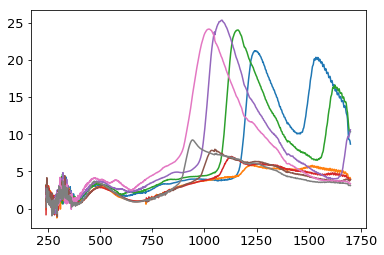

In [41]:
pathToData = 'file://localhost' + os.getcwd() + '/data/GratingCCL_OPC_520_90_740_medium_ref_angleDep.csv'

n_rows = 970
loaded_data = pandas.read_csv(pathToData, header=1, nrows=n_rows)

for x in range(int(loaded_data.shape[1]/2)):
    plt.plot(loaded_data.iloc[:,2*x],loaded_data.iloc[:,2*x+1])

plt.show()

measured_points = loaded_data.iloc[:,0]
measured_ref_6_s = loaded_data.iloc[:,1]
measured_ref_6_p = loaded_data.iloc[:,3]
measured_ref_10_s = loaded_data.iloc[:,5]
measured_ref_10_p = loaded_data.iloc[:,7]
measured_ref_14_s = loaded_data.iloc[:,9]
measured_ref_14_p = loaded_data.iloc[:,11]
measured_ref_18_s = loaded_data.iloc[:,13]
measured_ref_18_p = loaded_data.iloc[:,15]


In [5]:
path_coating_jedna = 'file://localhost' + os.getcwd() + '/data/coating_spline_jedna_vrstva.csv'

wv_coating_jedna = pandas.read_csv(path_coating_jedna,header=0,sep='\t')

wv_array = wv_coating_jedna.iloc[:,0].values / 10
wv_coating_jedna = wv_coating_jedna.iloc[:,1].values - 1j * wv_coating_jedna.iloc[:,2].values

every_nth = 8
wv_array = wv_array[1::every_nth]
wv_coating_jedna = wv_coating_jedna[1::every_nth]

path_coating_old = 'file://localhost' + os.getcwd() + '/data/CCL_grid_lak.csv'
path_substrate_old = 'file://localhost' + os.getcwd() + '/data/CCL_grid_substrate.csv'

wv_coating_old = pandas.read_csv(path_coating_old,header=0,sep='\t')
wv_substrate_old = pandas.read_csv(path_substrate_old,header=0,sep='\t')

wv_coating_old = wv_coating_old.iloc[:,1].values - 1j * wv_coating_old.iloc[:,2].values
wv_substrate_old = wv_substrate_old.iloc[:,1].values - 1j * wv_substrate_old.iloc[:,2].values

wv_coating_old = wv_coating_old[1::every_nth]
wv_substrate_old = wv_substrate_old[1::every_nth]


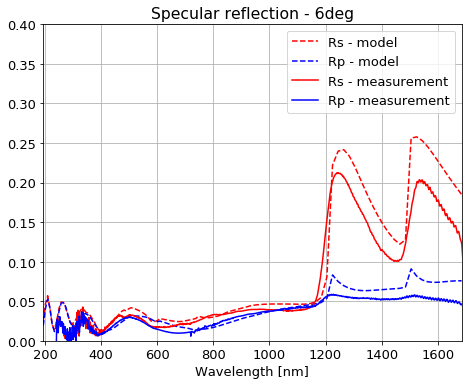

CPU times: user 32 s, sys: 622 ms, total: 32.6 s
Wall time: 16.9 s


In [17]:
%%time

def general_func_temp(wvs, options_input, angle):
    
    def get_structure_and_options(index):
        
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 10,
            'n_select': 3,
            'wavelength': wvs[index],
            'angle': angle,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        width_grating = 530
            
        perm_substrate = wv_substrate_old[index]
        
        structure = {
            'bound_selectors': [
                # ['data', 0, 'permittivity', 4],

                # ['data', 0, 'permittivity', 8],
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1000000/740,
            'data': [
                {'width': width_grating, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0, perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': 50000, 'periodic': False, 'coherent': False,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]},
                 
            ]}
        
        return options, structure

    def calculate_from_structure_and_options(index):
        options, structure = get_structure_and_options(index)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    indexes = range(wvs.size)
    results = list(map(calculate_from_structure_and_options,indexes))
    

    return get_coeffs(np.array(results))[0]

options_input = {
    'divisions': wv_array.size,
    'divisions_start': wv_array[0],
    'divisions_end': wv_array[-1],
    'dependence': {
        'name': 'wavelength',  ##angle // wavelength // structure
        'label': 'Wavelength [nm]'
    }
}

values = np.real(general_func_temp(wv_array, options_input, 6))

font = {'size': 13, 'weight': 'normal'}

matplotlib.rc('font', **font)

fig3 = plt.figure(15, figsize=(6.75, 5.55))
plt.title("Specular reflection - 6deg")
plt.plot(wv_array, values[:, 0, 0], 'r--', label='Rs - model')
plt.plot(wv_array, values[:, 1, 0], 'b--', label='Rp - model')
plt.plot(measured_points, measured_ref_6_s/100, 'r-', label='Rs - measurement')
plt.plot(measured_points, measured_ref_6_p/100, 'b-', label='Rp - measurement')
# max = np.array([values[:, 0, 0], values[:, 1, 0]]).max()
plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0, 0.4])
plt.xlabel(options_input['dependence']['label'])
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


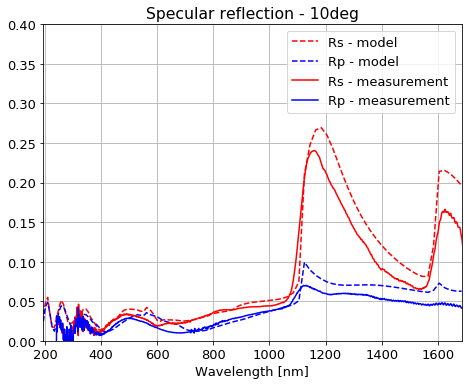

CPU times: user 36.5 s, sys: 767 ms, total: 37.2 s
Wall time: 21.1 s


In [42]:
%%time

def general_func_temp(wvs, options_input, angle):
    
    def get_structure_and_options(index):
        
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 10,
            'n_select': 3,
            'wavelength': wvs[index],
            'angle': angle,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        width_grating = 530
            
        perm_substrate = wv_substrate_old[index]
        
        structure = {
            'bound_selectors': [
                # ['data', 0, 'permittivity', 4],

                # ['data', 0, 'permittivity', 8],
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1000000/740,
            'data': [
                {'width': width_grating, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0, perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': 50000, 'periodic': False, 'coherent': False,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]},
                 
            ]}
        
        return options, structure

    def calculate_from_structure_and_options(index):
        options, structure = get_structure_and_options(index)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    indexes = range(wvs.size)
    results = list(map(calculate_from_structure_and_options,indexes))
    

    return get_coeffs(np.array(results))[0]

options_input = {
    'divisions': wv_array.size,
    'divisions_start': wv_array[0],
    'divisions_end': wv_array[-1],
    'dependence': {
        'name': 'wavelength',  ##angle // wavelength // structure
        'label': 'Wavelength [nm]'
    }
}

values = np.real(general_func_temp(wv_array, options_input, 10))

font = {'size': 13, 'weight': 'normal'}

matplotlib.rc('font', **font)

fig3 = plt.figure(15, figsize=(6.75, 5.55))
plt.title("Specular reflection - 10deg")
plt.plot(wv_array, values[:, 0, 0], 'r--', label='Rs - model')
plt.plot(wv_array, values[:, 1, 0], 'b--', label='Rp - model')
plt.plot(measured_points, measured_ref_10_s/100, 'r-', label='Rs - measurement')
plt.plot(measured_points, measured_ref_10_p/100, 'b-', label='Rp - measurement')
# max = np.array([values[:, 0, 0], values[:, 1, 0]]).max()
plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0, 0.4])
plt.xlabel(options_input['dependence']['label'])
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


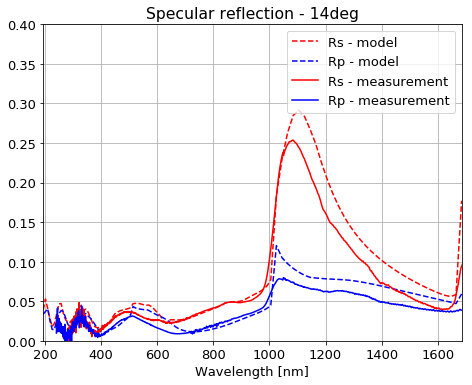

CPU times: user 38.8 s, sys: 863 ms, total: 39.6 s
Wall time: 21.9 s


In [43]:
%%time

def general_func_temp(wvs, options_input, angle):
    
    def get_structure_and_options(index):
        
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 10,
            'n_select': 3,
            'wavelength': wvs[index],
            'angle': angle,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        width_grating = 530
            
        perm_substrate = wv_substrate_old[index]
        
        structure = {
            'bound_selectors': [
                # ['data', 0, 'permittivity', 4],

                # ['data', 0, 'permittivity', 8],
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1000000/740,
            'data': [
                {'width': width_grating, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0, perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': 50000, 'periodic': False, 'coherent': False,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]},
                 
            ]}
        
        return options, structure

    def calculate_from_structure_and_options(index):
        options, structure = get_structure_and_options(index)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    indexes = range(wvs.size)
    results = list(map(calculate_from_structure_and_options,indexes))
    

    return get_coeffs(np.array(results))[0]

options_input = {
    'divisions': wv_array.size,
    'divisions_start': wv_array[0],
    'divisions_end': wv_array[-1],
    'dependence': {
        'name': 'wavelength',  ##angle // wavelength // structure
        'label': 'Wavelength [nm]'
    }
}

values = np.real(general_func_temp(wv_array, options_input, 14))

font = {'size': 13, 'weight': 'normal'}

matplotlib.rc('font', **font)

fig3 = plt.figure(15, figsize=(6.75, 5.55))
plt.title("Specular reflection - 14deg")
plt.plot(wv_array, values[:, 0, 0], 'r--', label='Rs - model')
plt.plot(wv_array, values[:, 1, 0], 'b--', label='Rp - model')
plt.plot(measured_points, measured_ref_14_s/100, 'r-', label='Rs - measurement')
plt.plot(measured_points, measured_ref_14_p/100, 'b-', label='Rp - measurement')
# max = np.array([values[:, 0, 0], values[:, 1, 0]]).max()
plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0, 0.4])
plt.xlabel(options_input['dependence']['label'])
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


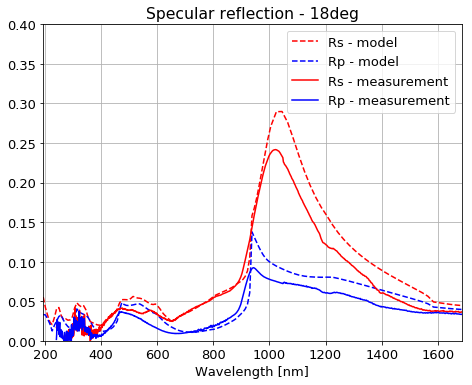

CPU times: user 36 s, sys: 765 ms, total: 36.7 s
Wall time: 20.1 s


In [44]:
%%time

def general_func_temp(wvs, options_input, angle):
    
    def get_structure_and_options(index):
        
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 10,
            'n_select': 3,
            'wavelength': wvs[index],
            'angle': angle,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        width_grating = 530
            
        perm_substrate = wv_substrate_old[index]
        
        structure = {
            'bound_selectors': [
                # ['data', 0, 'permittivity', 4],

                # ['data', 0, 'permittivity', 8],
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1000000/740,
            'data': [
                {'width': width_grating, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0, perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': 50000, 'periodic': False, 'coherent': False,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]},
                 
            ]}
        
        return options, structure

    def calculate_from_structure_and_options(index):
        options, structure = get_structure_and_options(index)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    indexes = range(wvs.size)
    results = list(map(calculate_from_structure_and_options,indexes))
    

    return get_coeffs(np.array(results))[0]

options_input = {
    'divisions': wv_array.size,
    'divisions_start': wv_array[0],
    'divisions_end': wv_array[-1],
    'dependence': {
        'name': 'wavelength',  ##angle // wavelength // structure
        'label': 'Wavelength [nm]'
    }
}

values = np.real(general_func_temp(wv_array, options_input, 18))

font = {'size': 13, 'weight': 'normal'}

matplotlib.rc('font', **font)

fig3 = plt.figure(15, figsize=(6.75, 5.55))
plt.title("Specular reflection - 18deg")
plt.plot(wv_array, values[:, 0, 0], 'r--', label='Rs - model')
plt.plot(wv_array, values[:, 1, 0], 'b--', label='Rp - model')
plt.plot(measured_points, measured_ref_18_s/100, 'r-', label='Rs - measurement')
plt.plot(measured_points, measured_ref_18_p/100, 'b-', label='Rp - measurement')
# max = np.array([values[:, 0, 0], values[:, 1, 0]]).max()
plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0, 0.4])
plt.xlabel(options_input['dependence']['label'])
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


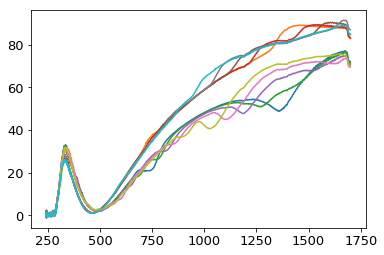

In [29]:
pathToData_trans = 'file://localhost' + os.getcwd() + '/data/GratingCCL_OPC_520_90_740_medium_trans_angleDep.csv'

n_rows = 970
loaded_data_trans = pandas.read_csv(pathToData_trans, header=1, nrows=n_rows)

for x in range(int(loaded_data_trans.shape[1]/2)):
    plt.plot(loaded_data_trans.iloc[:,2*x],loaded_data_trans.iloc[:,2*x+1])

plt.show()

measured_points = loaded_data_trans.iloc[:,0]
measured_trans_0_s = loaded_data_trans.iloc[:,1]
measured_trans_0_p = loaded_data_trans.iloc[:,3]
measured_trans_4_s = loaded_data_trans.iloc[:,5]
measured_trans_4_p = loaded_data_trans.iloc[:,7]
measured_trans_8_s = loaded_data_trans.iloc[:,9]
measured_trans_8_p = loaded_data_trans.iloc[:,11]
measured_trans_12_s = loaded_data_trans.iloc[:,13]
measured_trans_12_p = loaded_data_trans.iloc[:,15]
measured_trans_16_s = loaded_data_trans.iloc[:,17]
measured_trans_16_p = loaded_data_trans.iloc[:,19]



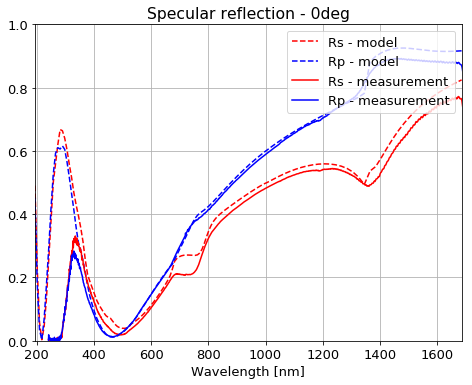

CPU times: user 33.3 s, sys: 738 ms, total: 34 s
Wall time: 18 s


In [36]:
%%time

def general_func_temp(wvs, options_input, angle):
    
    def get_structure_and_options(index):
        
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 10,
            'n_select': 3,
            'wavelength': wvs[index],
            'angle': angle,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        width_grating = 530
            
        perm_substrate = wv_substrate_old[index]
        
        structure = {
            'bound_selectors': [
                # ['data', 0, 'permittivity', 4],

                # ['data', 0, 'permittivity', 8],
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1000000/740,
            'data': [
                {'width': width_grating, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0, perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': 50000, 'periodic': False, 'coherent': False,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]},
                 
            ]}
        
        return options, structure

    def calculate_from_structure_and_options(index):
        options, structure = get_structure_and_options(index)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    indexes = range(wvs.size)
    results = list(map(calculate_from_structure_and_options,indexes))
    

    return get_coeffs(np.array(results))[0]

options_input = {
    'divisions': wv_array.size,
    'divisions_start': wv_array[0],
    'divisions_end': wv_array[-1],
    'dependence': {
        'name': 'wavelength',  ##angle // wavelength // structure
        'label': 'Wavelength [nm]'
    }
}

values = np.real(general_func_temp(wv_array, options_input, 0))

font = {'size': 13, 'weight': 'normal'}

matplotlib.rc('font', **font)

fig3 = plt.figure(15, figsize=(6.75, 5.55))
plt.title("Specular reflection - 0deg")
plt.plot(wv_array, values[:, 2, 0], 'r--', label='Rs - model')
plt.plot(wv_array, values[:, 3, 0], 'b--', label='Rp - model')
plt.plot(measured_points, measured_trans_0_s/100, 'r-', label='Rs - measurement')
plt.plot(measured_points, measured_trans_0_p/100, 'b-', label='Rp - measurement')
# max = np.array([values[:, 0, 0], values[:, 1, 0]]).max()
plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0, 1])
plt.xlabel(options_input['dependence']['label'])
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


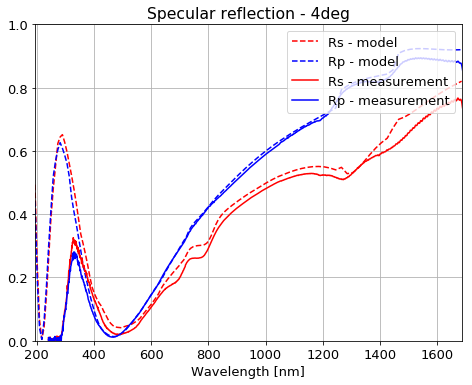

CPU times: user 35 s, sys: 739 ms, total: 35.7 s
Wall time: 18.8 s


In [37]:
%%time

def general_func_temp(wvs, options_input, angle):
    
    def get_structure_and_options(index):
        
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 10,
            'n_select': 3,
            'wavelength': wvs[index],
            'angle': angle,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        width_grating = 530
            
        perm_substrate = wv_substrate_old[index]
        
        structure = {
            'bound_selectors': [
                # ['data', 0, 'permittivity', 4],

                # ['data', 0, 'permittivity', 8],
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1000000/740,
            'data': [
                {'width': width_grating, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0, perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': 50000, 'periodic': False, 'coherent': False,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]},
                 
            ]}
        
        return options, structure

    def calculate_from_structure_and_options(index):
        options, structure = get_structure_and_options(index)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    indexes = range(wvs.size)
    results = list(map(calculate_from_structure_and_options,indexes))
    

    return get_coeffs(np.array(results))[0]

options_input = {
    'divisions': wv_array.size,
    'divisions_start': wv_array[0],
    'divisions_end': wv_array[-1],
    'dependence': {
        'name': 'wavelength',  ##angle // wavelength // structure
        'label': 'Wavelength [nm]'
    }
}

values = np.real(general_func_temp(wv_array, options_input, 4))

font = {'size': 13, 'weight': 'normal'}

matplotlib.rc('font', **font)

fig3 = plt.figure(15, figsize=(6.75, 5.55))
plt.title("Specular reflection - 4deg")
plt.plot(wv_array, values[:, 2, 0], 'r--', label='Rs - model')
plt.plot(wv_array, values[:, 3, 0], 'b--', label='Rp - model')
plt.plot(measured_points, measured_trans_4_s/100, 'r-', label='Rs - measurement')
plt.plot(measured_points, measured_trans_4_p/100, 'b-', label='Rp - measurement')
# max = np.array([values[:, 0, 0], values[:, 1, 0]]).max()
plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0, 1])
plt.xlabel(options_input['dependence']['label'])
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


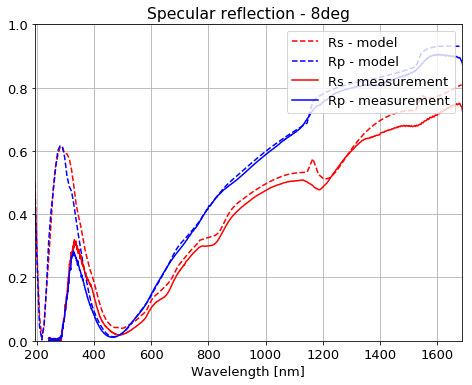

CPU times: user 35.9 s, sys: 757 ms, total: 36.7 s
Wall time: 19.7 s


In [38]:
%%time

def general_func_temp(wvs, options_input, angle):
    
    def get_structure_and_options(index):
        
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 10,
            'n_select': 3,
            'wavelength': wvs[index],
            'angle': angle,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        width_grating = 530
            
        perm_substrate = wv_substrate_old[index]
        
        structure = {
            'bound_selectors': [
                # ['data', 0, 'permittivity', 4],

                # ['data', 0, 'permittivity', 8],
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1000000/740,
            'data': [
                {'width': width_grating, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0, perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': 50000, 'periodic': False, 'coherent': False,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]},
                 
            ]}
        
        return options, structure

    def calculate_from_structure_and_options(index):
        options, structure = get_structure_and_options(index)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    indexes = range(wvs.size)
    results = list(map(calculate_from_structure_and_options,indexes))
    

    return get_coeffs(np.array(results))[0]

options_input = {
    'divisions': wv_array.size,
    'divisions_start': wv_array[0],
    'divisions_end': wv_array[-1],
    'dependence': {
        'name': 'wavelength',  ##angle // wavelength // structure
        'label': 'Wavelength [nm]'
    }
}

values = np.real(general_func_temp(wv_array, options_input, 8))

font = {'size': 13, 'weight': 'normal'}

matplotlib.rc('font', **font)

fig3 = plt.figure(15, figsize=(6.75, 5.55))
plt.title("Specular reflection - 8deg")
plt.plot(wv_array, values[:, 2, 0], 'r--', label='Rs - model')
plt.plot(wv_array, values[:, 3, 0], 'b--', label='Rp - model')
plt.plot(measured_points, measured_trans_8_s/100, 'r-', label='Rs - measurement')
plt.plot(measured_points, measured_trans_8_p/100, 'b-', label='Rp - measurement')
# max = np.array([values[:, 0, 0], values[:, 1, 0]]).max()
plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0, 1])
plt.xlabel(options_input['dependence']['label'])
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


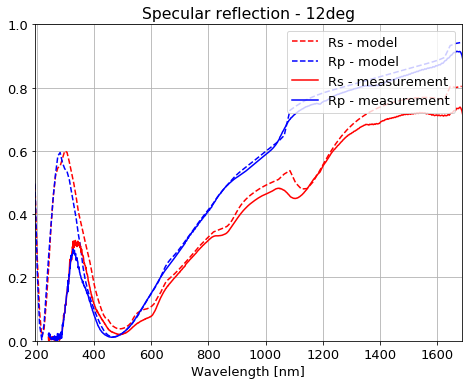

CPU times: user 37.5 s, sys: 801 ms, total: 38.3 s
Wall time: 20.6 s


In [39]:
%%time

def general_func_temp(wvs, options_input, angle):
    
    def get_structure_and_options(index):
        
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 10,
            'n_select': 3,
            'wavelength': wvs[index],
            'angle': angle,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        width_grating = 530
            
        perm_substrate = wv_substrate_old[index]
        
        structure = {
            'bound_selectors': [
                # ['data', 0, 'permittivity', 4],

                # ['data', 0, 'permittivity', 8],
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1000000/740,
            'data': [
                {'width': width_grating, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0, perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': 50000, 'periodic': False, 'coherent': False,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]},
                 
            ]}
        
        return options, structure

    def calculate_from_structure_and_options(index):
        options, structure = get_structure_and_options(index)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    indexes = range(wvs.size)
    results = list(map(calculate_from_structure_and_options,indexes))
    

    return get_coeffs(np.array(results))[0]

options_input = {
    'divisions': wv_array.size,
    'divisions_start': wv_array[0],
    'divisions_end': wv_array[-1],
    'dependence': {
        'name': 'wavelength',  ##angle // wavelength // structure
        'label': 'Wavelength [nm]'
    }
}

values = np.real(general_func_temp(wv_array, options_input, 12))

font = {'size': 13, 'weight': 'normal'}

matplotlib.rc('font', **font)

fig3 = plt.figure(15, figsize=(6.75, 5.55))
plt.title("Specular reflection - 12deg")
plt.plot(wv_array, values[:, 2, 0], 'r--', label='Rs - model')
plt.plot(wv_array, values[:, 3, 0], 'b--', label='Rp - model')
plt.plot(measured_points, measured_trans_12_s/100, 'r-', label='Rs - measurement')
plt.plot(measured_points, measured_trans_12_p/100, 'b-', label='Rp - measurement')
# max = np.array([values[:, 0, 0], values[:, 1, 0]]).max()
plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0, 1])
plt.xlabel(options_input['dependence']['label'])
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


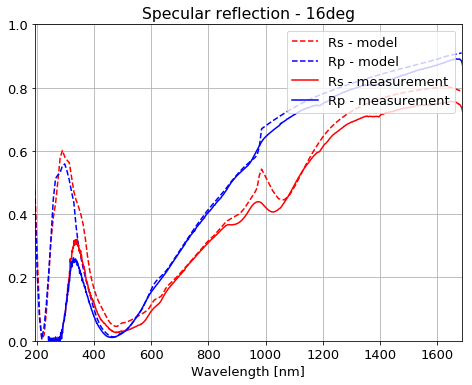

CPU times: user 39.5 s, sys: 939 ms, total: 40.4 s
Wall time: 23.9 s


In [40]:
%%time

def general_func_temp(wvs, options_input, angle):
    
    def get_structure_and_options(index):
        
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 10,
            'n_select': 3,
            'wavelength': wvs[index],
            'angle': angle,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        width_grating = 530
            
        perm_substrate = wv_substrate_old[index]
        
        structure = {
            'bound_selectors': [
                # ['data', 0, 'permittivity', 4],

                # ['data', 0, 'permittivity', 8],
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1000000/740,
            'data': [
                {'width': width_grating, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0, perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': 50000, 'periodic': False, 'coherent': False,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]},
                 
            ]}
        
        return options, structure

    def calculate_from_structure_and_options(index):
        options, structure = get_structure_and_options(index)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    indexes = range(wvs.size)
    results = list(map(calculate_from_structure_and_options,indexes))
    

    return get_coeffs(np.array(results))[0]

options_input = {
    'divisions': wv_array.size,
    'divisions_start': wv_array[0],
    'divisions_end': wv_array[-1],
    'dependence': {
        'name': 'wavelength',  ##angle // wavelength // structure
        'label': 'Wavelength [nm]'
    }
}

values = np.real(general_func_temp(wv_array, options_input, 16))

font = {'size': 13, 'weight': 'normal'}

matplotlib.rc('font', **font)

fig3 = plt.figure(15, figsize=(6.75, 5.55))
plt.title("Specular reflection - 16deg")
plt.plot(wv_array, values[:, 2, 0], 'r--', label='Rs - model')
plt.plot(wv_array, values[:, 3, 0], 'b--', label='Rp - model')
plt.plot(measured_points, measured_trans_16_s/100, 'r-', label='Rs - measurement')
plt.plot(measured_points, measured_trans_16_p/100, 'b-', label='Rp - measurement')
# max = np.array([values[:, 0, 0], values[:, 1, 0]]).max()
plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0, 1])
plt.xlabel(options_input['dependence']['label'])
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
